<a href="https://colab.research.google.com/github/Shaheer04/Budgetier/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=d57ad4a65b29435a96dc113ebfd7eaee44f08f5b95a1c427ff8877ab4b390ecf
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
!pip install keras

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re

# Data Preprocessing

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/tweet_emotions.csv')

In [5]:
dataset.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [6]:
dataset.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


<Axes: xlabel='sentiment'>

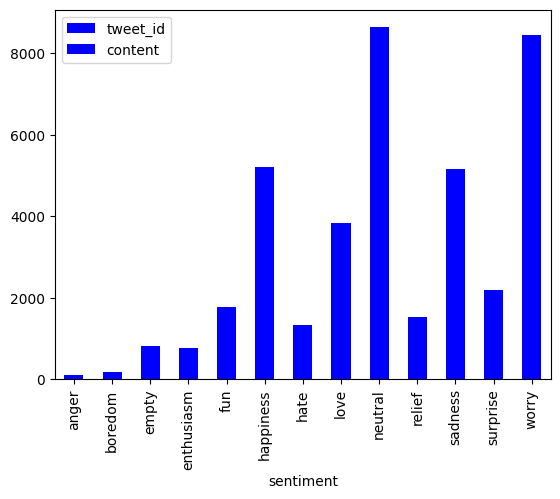

In [7]:
dataset.groupby('sentiment').count().plot.bar(color='blue')

<ipython-input-8-f720a3e7ae26>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.content.str.len())


<Axes: xlabel='content', ylabel='Density'>

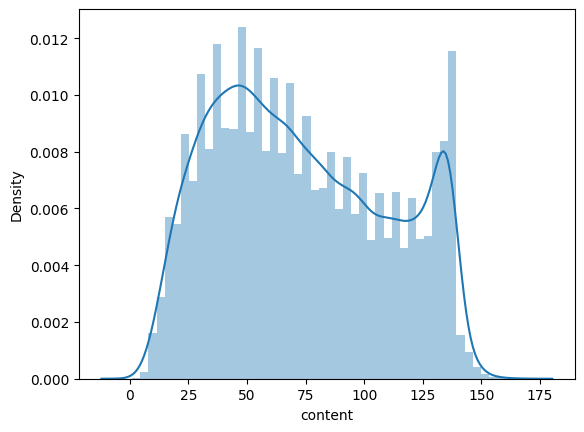

In [8]:
sns.distplot(dataset.content.str.len())

In [9]:
dataset = dataset.drop(['tweet_id'], axis=1)
dataset.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [10]:
dataset['content'] = dataset['content'].apply(str.lower)
dataset.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,layin n bed with a headache ughhhh...waitin o...
2,sadness,funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends soon!
4,neutral,@dannycastillo we want to trade with someone w...


In [11]:
labels, features = [],[]
labels = pd.get_dummies(dataset['sentiment']).values
dataset = dataset.drop(['sentiment'], axis=1)

features = dataset.content.astype(str).values

In [12]:
labels

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
features

array(['@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[',
       'layin n bed with a headache  ughhhh...waitin on your call...',
       'funeral ceremony...gloomy friday...', ...,
       "happy mother's day to all the mommies out there, be you woman or man as long as you're 'momma' to someone this is your day!",
       '@niariley wassup beautiful!!! follow me!!  peep out my new hit singles www.myspace.com/ipsohot i def. wat u in the video!!',
       '@mopedronin bullet train from tokyo    the gf and i have been visiting japan since thursday  vacation/sightseeing    gaijin godzilla'],
      dtype=object)

In [14]:
X_train,X_val,y_train,y_val = train_test_split(features, labels, test_size=0.25)

In [15]:
X_train.shape,y_train.shape

((30000,), (30000, 13))

In [16]:
X_val.shape,y_val.shape

((10000,), (10000, 13))

# Now making the Model

In [17]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
from official.nlp import optimization
import tensorflow_hub as hub
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 28.1 MB/s eta 0:00:00


In [19]:
bert_model_name_encoder = 'bert_en_uncased_L-12_H-768_A-12'
encoder_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model_name_preprocess = 'bert_en_uncased_L-12_H-768_A-12'
preprocess_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [20]:
bert_preprocessor = hub.KerasLayer(preprocess_download_link, name='preprocessing')
bert_encoder = hub.KerasLayer(encoder_download_link, name='BERT_encoder')

In [21]:
def classifier_model():
  text_input = Input(shape =(), dtype= tf.string, name='text')
  #preprocesing layer
  preprocessed_text = bert_preprocessor(text_input)
  #passing through encoder layer
  embeddings = bert_encoder(preprocessed_text)
  #fetching the pooled_output from the dictionary of outputs
  output = embeddings['pooled_output']
  output = Dropout(0.2)(output)
  #passing through final dense layer with softmax
  output = Dense(13, activation=None, name='classifier_end')(output)
  return Model(text_input, output)

classifier = classifier_model()

In [22]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [23]:
loss = CategoricalCrossentropy(from_logits=True)
metrics = CategoricalAccuracy()

In [24]:
steps_per_epoch =len(X_train)
num_train_steps = steps_per_epoch * 10
num_warmup_steps = int(0.01*num_train_steps)

init_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
"""optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')"""

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

"optimization.create_optimizer(init_lr=init_lr,\n                                          num_train_steps=num_train_steps,\n                                          num_warmup_steps=num_warmup_steps,\n                                          optimizer_type='adamw')"

In [25]:
classifier.compile(optimizer = optimizer, loss=loss, metrics=metrics, callbacks=[cp_callback])

In [26]:
#fitting the model
history = classifier.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1)

938/938 [==============================] - 456s 461ms/step - loss: 2.1736 - categorical_accuracy: 0.2451 - val_loss: 2.0511 - val_categorical_accuracy: 0.2911


# Evaluating the Model

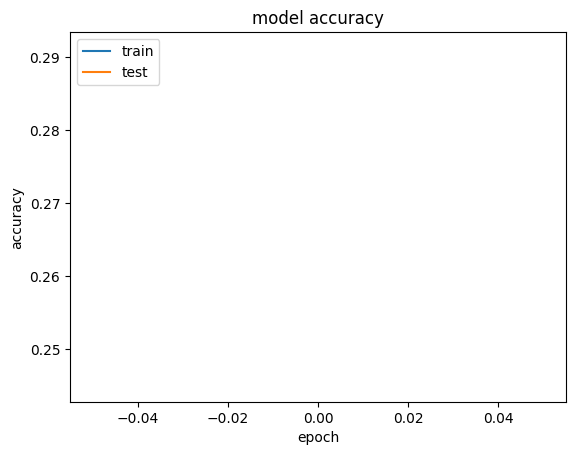

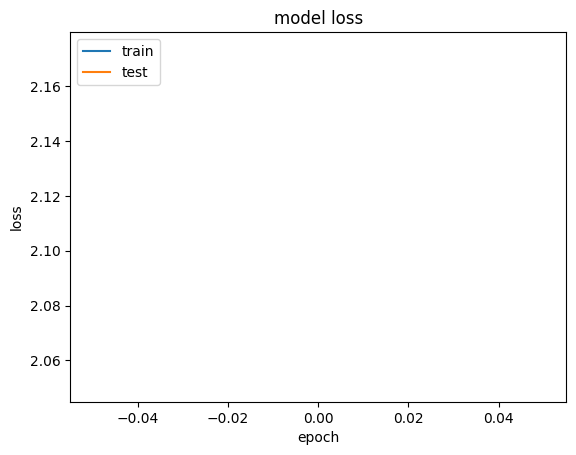

In [30]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [33]:
# new_model = tf.keras.models.save_model('Bert_model.keras', filepath='/content/')

tf.keras.models.save_model(classifier, '/content/bert_model.keras')

In [34]:
test_string1 = ["I am not coming tomorrow afternoon"]
test_string2 = ["I hate you"]

def predict(test_string):
  class_prob = classifier.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    print("Negative Sentiment")
  elif np.argmax(class_prob)==1:
    print("Neutral Sentiment")
  else:
    print("Positive Sentiment")

predict(test_string1)
predict(test_string2)

1/1 [==============================] - 1s 798ms/step
Positive Sentiment
1/1 [==============================] - 0s 38ms/step
Positive Sentiment
